# Setting up the case study


In [1]:
# import statements
from src.model_configuration import ModelConfiguration
import src.data_management as dm
from src.energyhub import EnergyHub
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Save Data File to file
data_save_path = Path('./user_data/data_handle_test')

The following piece of code shows the system topology, i.e., which technologies are part of the system and what is the time horizon. To assess the Ocean Battery technology as a stand-alone technology connected to the grid, the system consists solely of this technology. The time horizon is set for one week. 

Insert figure of difference specific and general model: show what is determined per slot and what for the whole tech?

In [2]:
# TOPOLOGY
topology = dm.SystemTopology()
topology.define_time_horizon(year=2001,start_date='01-01 00:00', end_date='01-07 00:00', resolution=1)
topology.define_carriers(['electricity'])
topology.define_nodes(['onshore'])
topology.define_new_technologies('onshore', ['Storage_OceanBattery_specific_2'])

# Initialize instance of DataHandle
data = dm.DataHandle(topology)

Then, we import all data needed for the scenario. This consists of the climate data (even though the technology is not related to climate data this is needed for the model to run) as well as import and export data. For the latter, price profiles of 2019 (day-ahead prices of NL bidding zone) are used (same profile for both import and export). 

In [3]:
# CLIMATE DATA
from_file = 1
if from_file == 1:
    data.read_climate_data_from_file('onshore', './data/climate_data_onshore.txt')

# IMPORT & EXPORT LIMITS
el_import = np.ones(len(topology.timesteps)) * 100
data.read_import_limit_data('onshore', 'electricity', el_import)

el_export = np.ones(len(topology.timesteps)) * 100
data.read_export_limit_data('onshore', 'electricity', el_export)

# IMPORT & EXPORT PRICES

el_price_profile_2019 = pd.read_csv(".\ob_input_data\day_ahead_2019.csv", header=0)
el_price_profile_2019 = np.array(el_price_profile_2019.iloc[:, 1])
el_price_profile_2019 = el_price_profile_2019[0:len(topology.timesteps)]

data.read_import_price_data('onshore', 'electricity', el_price_profile_2019)
data.read_export_price_data('onshore', 'electricity', el_price_profile_2019)

C:\Users\6145795\Documents\GitHub\EHUB-Py\src\data_management\utilities.py:159: UserWarning: Time series is longer than chosen time horizon - taking only the first couple of time slices
  warnings.warn('Time series is longer than chosen time horizon - taking only the first ' + \


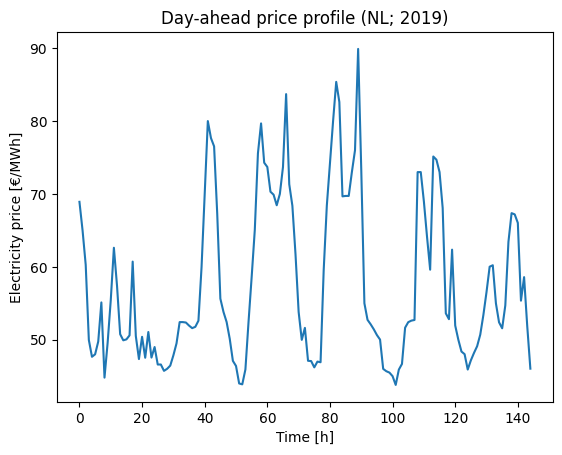

In [4]:
plt.plot(el_price_profile_2019)
plt.xlabel('Time [h]')
plt.ylabel('Electricity price [€/MWh]')
plt.title('Day-ahead price profile (NL; 2019)')
plt.show()

# Model and results
After the data is put in, the model is solved.

In [5]:
# READ TECHNOLOGY AND NETWORK DATA
data.read_technology_data()
data.read_network_data()

# SAVING/LOADING DATA FILE
configuration = ModelConfiguration()

# Read data
energyhub = EnergyHub(data, configuration)
results = energyhub.quick_solve()

C:\Users\6145795\Documents\GitHub\EHUB-Py\src\components\technologies\specificTechnologies\ocean_battery_specific_2.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.performance_data['pump_performance'][pump]['P_in'] = self.performance_data['pump_performance'][pump]['P_in'] / max(self.performance_data['pump_performance'][pump]['P_in'])
C:\Users\6145795\Documents\GitHub\EHUB-Py\src\components\technologies\specificTechnologies\ocean_battery_specific_2.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

____________________________________________________________
Reading in data...
Reading in data completed in 0 s
____________________________________________________________
____________________________________________________________
Constructing Model...
____________________________________________________________
--- Adding Networks... ---
____________________________________________________________
--- Adding Node onshore... ---
	 - Adding Technology Storage_OceanBattery_specific_2
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 1 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformation completed in 1 s
		Big-M Transformation...
		Big-M Transformation completed in 0 s
		Big-M Transformation...
		Big-M Transformatio

## Design results
- Size of reservoir
- Pump & turbine size
- Pump & turbine type
- Capex per slot (installed yes or no)

In [6]:
b_tec = energyhub.model.node_blocks['onshore'].tech_blocks_active['Storage_OceanBattery_specific_2']

design = {}
design['Reservoir size [m3]:'] = b_tec.var_size.value
design['Single pump size [MW]:'] = b_tec.var_size_single_pump.value
design['Single turbine size [MW]:'] = b_tec.var_size_single_turbine.value

for pump_type in range(1, 4):
    if b_tec.dis_pump_type[pump_type].indicator_var.value:
        design['Pump type value (1: Axial; 2: Mixed-flow; 3: Radial)'] = pump_type

for turbine_type in range(1, 4):
    if b_tec.dis_turbine_type[turbine_type].indicator_var.value:
        design['Turbine type value (1: Francis; 2: Kaplan; 3: Pelton)'] = turbine_type

for pump in b_tec.set_pump_slots:
    design['Capex pump_' + str(pump)] = b_tec.var_capex_pump[pump].value

for turb in b_tec.set_pump_slots:
    design['Capex turbine_' + str(turb)] = b_tec.var_capex_turbine[turb].value

design_df = pd.DataFrame(data=design, index=[0]).T

print(design_df)

                                                             0
Reservoir size [m3]:                                920.408163
Single pump size [MW]:                               10.000000
Single turbine size [MW]:                            10.000000
Pump type value (1: Axial; 2: Mixed-flow; 3: Ra...    1.000000
Turbine type value (1: Francis; 2: Kaplan; 3: P...    1.000000
Capex pump_1                                          1.627454
Capex pump_2                                          1.627454
Capex turbine_1                                       1.627454
Capex turbine_2                                       1.627454


## Operation results

Plots of OB functioning:
- Hourly storage level/discharge/charge 

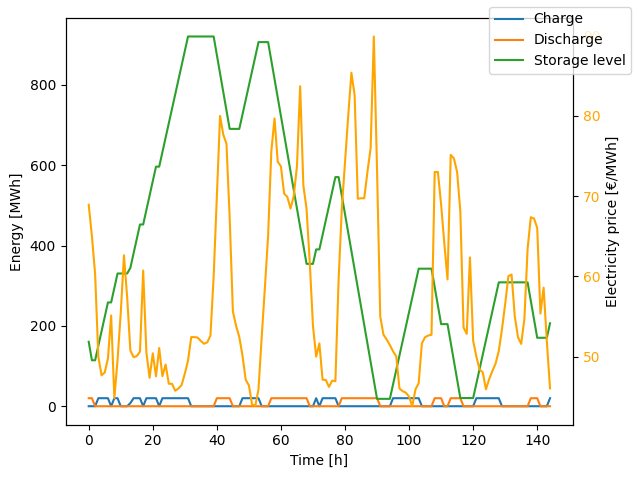

In [7]:
# Results = pd.Excelfile(r'.\userData\OB\')

set_t_full = energyhub.model.set_t_full

SOC = [b_tec.var_storage_level[t].value for t in set_t_full]
Charge = [b_tec.var_input[t, 'electricity'].value for t in set_t_full]
Discharge = [b_tec.var_output[t, 'electricity'].value for t in set_t_full]

fig, ax1 = plt.subplots()
ax1.plot(Charge, label='Charge')
ax1.plot(Discharge, label='Discharge')
ax1.plot(SOC, label='Storage level')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Energy [MWh]')

ax2 = ax1.twinx()
ax2.plot(el_price_profile_2019, color='orange')
ax2.set_ylabel('Electricity price [€/MWh]')
ax2.tick_params(axis='y', labelcolor='orange')

fig.tight_layout()
fig.legend()
plt.show()